In [1]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import hdp_scripts as hdp
import multivariate_normal
import classification_evaluation as hdp_eval
import data_generation as gen
import imp # for reloading a local script
import time
imp.reload(multivariate_normal)
from multivariate_normal import MultivariateNormal
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

/Users/nickhoernle/anaconda2/envs/ipython3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

# Index:
- [Basic unit tests](#1)
- [Running a 1D AR(1) test](#2)
- [Running a multidimensional AR(1) test](#3)
- [Running a 1D AR(2) test](#4)
- [Running a multidimensional SLDS test](#5)

<a id=1></a>
# Test the MVN class

In [2]:
print(stats.multivariate_normal(np.zeros(2), np.eye(2)).logpdf(np.ones(2)))
print(MultivariateNormal(np.zeros(2), np.eye(2)).logpdf(np.ones(2)))
print(MultivariateNormal([np.zeros(2) for i in range(2)], [np.eye(2) for i in range(2)]).logpdf(np.ones(2)))
print(MultivariateNormal([[np.zeros(2) for i in range(2)] for j in range(2)], [[np.eye(2) for i in range(2)] for j in range(2)]).logpdf(np.ones(2)))

-2.8378770664093453
-2.8378770664093453
[-2.83787707 -2.83787707]
[[-2.83787707 -2.83787707]
 [-2.83787707 -2.83787707]]


<a id=2></a>
# 1D AR(1) Test (based on Gharamani and Hinton)

In [3]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

<module 'data_generation' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py'>

#### Generate the data

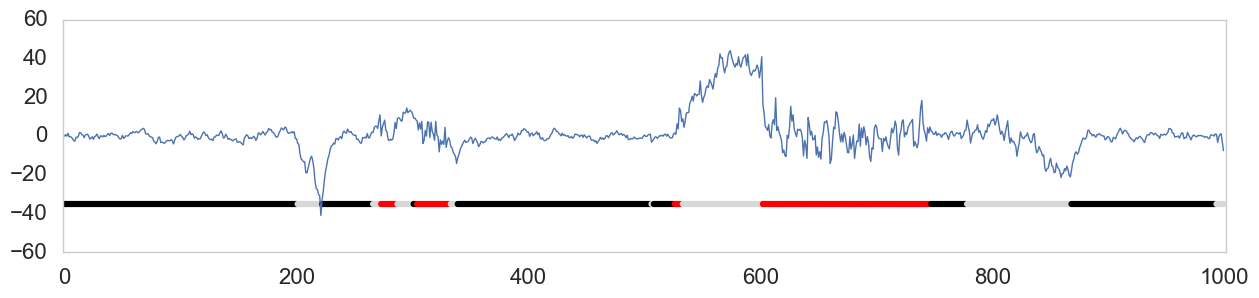

In [4]:
length = 1000
chain_params = [{"A": 0.8, "sigma": 1}, {"A": 0.99, "sigma": 10}, {"A": 0.5, "sigma": 25}]
res = gen.generate_data_1D(num_chains=len(chain_params), length=length, switch_prob=0.05, chain_params=chain_params)
chains, Y = res['chains'], res['Y'][:,0]

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,length,1)

c=['black','#d8d8d8', 'r', 'g', 'b', 'y', '#42e5f4', '#42e5f4', '#f47a41', 'blue',
  '#597757', '#576977', '#635777', '#635777', '#0FF000']

plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(Y, lw=1, alpha=1)
plt.xlim([-1,length+1])
plt.grid(False)

#### Run the inference - AR(1) model

In [5]:
params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.eye(D),
    'K': 5e-1*np.eye(D)
}

params, res, assignments = hdp.sticky_HDP_AR(Y, params, priors=[1*np.eye(1), 10],
                                             num_iter=100,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 2.70, hamming_dist: 765.000
Iteration: 10, # inf chain: 5, time: 2.64, hamming_dist: 41.000
Iteration: 20, # inf chain: 4, time: 2.57, hamming_dist: 45.000
Iteration: 30, # inf chain: 3, time: 2.56, hamming_dist: 49.000
Iteration: 40, # inf chain: 3, time: 2.71, hamming_dist: 39.000
Iteration: 50, # inf chain: 4, time: 2.63, hamming_dist: 38.000
Iteration: 60, # inf chain: 4, time: 2.61, hamming_dist: 52.000
Iteration: 70, # inf chain: 5, time: 2.45, hamming_dist: 49.000
Iteration: 80, # inf chain: 4, time: 2.74, hamming_dist: 45.000
Iteration: 90, # inf chain: 4, time: 2.63, hamming_dist: 45.000


#### Visualization of results

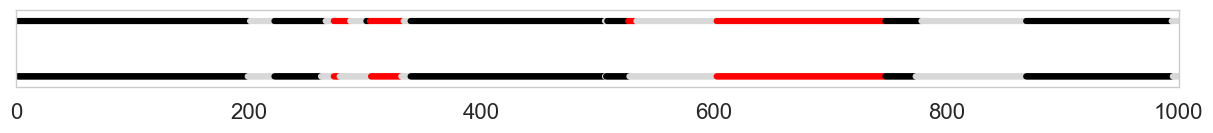

In [6]:
res = np.median(assignments[:,assignments.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

plt.figure(figsize=(15,1))
plt.scatter(np.linspace(0,len(res),num=len(res)), 1.5*np.ones_like(res), c=[c[i] for i in seq2_updated], lw=0)
plt.xlim([0,len(res)])
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(res)])

plt.yticks([])
plt.grid(False)

<a id=3></a>
# Now multivariate AR(1) model:

#### Generate the data

/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/data_generation.py:58: RuntimeWarning: covariance is not positive-semidefinite.
  return A.dot(x) + np.random.multivariate_normal(np.zeros(len(A)), sig)


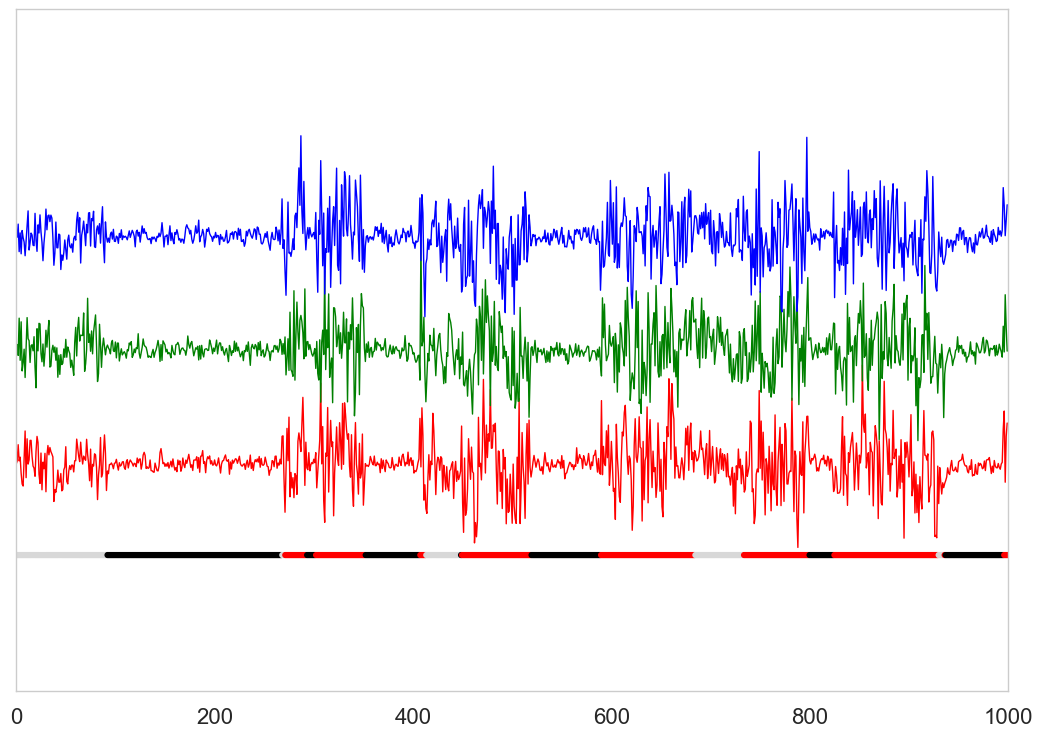

In [7]:
def generateTransitionMatrix(dim):
    A = np.random.dirichlet(10*np.ones(dim), size=3).T * np.random.beta(8,5) #+ 40*np.eye(dim) + 40*waterfall
    return A

def generateCovMatrix(dim, M, scale, reg):
    noise_cov = scale*(stats.matrix_normal(M, rowcov=1, colcov=1).rvs()+reg*np.eye(dim))/(reg+5)
    return noise_cov

Y = np.array([0,0,0]) # there are three observables
dim = 3

length = 1000
chain_params = [{"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)),.1 ,5)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)),1 ,5)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)),4 ,5)}]

res = gen.generate_data_nD(dim=3, num_chains=len(chain_params), length=length, switch_prob=0.05, chain_params=chain_params)
chains, Y = res['chains'], res['Y']
    
plt.plot(Y[:,0], lw=1, c='r')
plt.plot(Y[:,1] + 5, lw=1, c='g')
plt.plot(Y[:,2] + 10, lw=1, c='b')

plt.scatter(np.linspace(0,len(chains),num=len(chains)), -4*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(chains)])
plt.yticks([])
plt.grid(False)

#### Run the inference

In [8]:
params = {}
L = 10
D = 3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 10
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 10*np.eye(D)
}

params, res, assignments_ar1 = hdp.sticky_Multi_HDP_AR(Y, params, priors=[1*np.eye(D), 1e1],
                                             num_iter=200,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 1.64, hamming_dist: 845.000
Iteration: 10, # inf chain: 4, time: 2.07, hamming_dist: 72.000
Iteration: 20, # inf chain: 4, time: 2.12, hamming_dist: 20.000
Iteration: 30, # inf chain: 4, time: 2.12, hamming_dist: 19.000
Iteration: 40, # inf chain: 4, time: 2.11, hamming_dist: 22.000
Iteration: 50, # inf chain: 4, time: 2.02, hamming_dist: 21.000
Iteration: 60, # inf chain: 3, time: 2.12, hamming_dist: 22.000
Iteration: 70, # inf chain: 3, time: 1.97, hamming_dist: 26.000
Iteration: 80, # inf chain: 3, time: 1.94, hamming_dist: 17.000
Iteration: 90, # inf chain: 4, time: 2.03, hamming_dist: 23.000
Iteration: 100, # inf chain: 3, time: 2.04, hamming_dist: 17.000
Iteration: 110, # inf chain: 4, time: 2.05, hamming_dist: 31.000
Iteration: 120, # inf chain: 4, time: 2.02, hamming_dist: 22.000
Iteration: 130, # inf chain: 3, time: 2.08, hamming_dist: 17.000
Iteration: 140, # inf chain: 6, time: 2.02, hamming_dist: 24.000
Iteration: 150, # inf chain: 5, ti

#### Inference with AR(2) Model

In [ ]:
params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([np.array(np.eye(D)), np.array(np.eye(D))]),
                    'sigma': 1*np.array(np.eye(D))} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 10
params['priors'] = {
    # need to adjust the priors slightly
    'M': np.zeros(shape=(D,D*2)),
    'K': 10*np.eye(D*2)
}

params, res, assignments_ar2 = hdp.sticky_Multi_HDP_AR2(Y, params, priors=[1*np.eye(D), 1e1],
                                             num_iter=200,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

Iteration: 0, # inf chain: 10, time: 1.89, hamming_dist: 870.000
Iteration: 10, # inf chain: 6, time: 2.15, hamming_dist: 79.000
Iteration: 20, # inf chain: 4, time: 2.26, hamming_dist: 24.000
Iteration: 30, # inf chain: 4, time: 2.30, hamming_dist: 42.000
Iteration: 40, # inf chain: 4, time: 2.53, hamming_dist: 57.000
Iteration: 50, # inf chain: 4, time: 2.19, hamming_dist: 31.000
Iteration: 60, # inf chain: 4, time: 2.31, hamming_dist: 71.000
Iteration: 70, # inf chain: 4, time: 2.34, hamming_dist: 50.000
Iteration: 80, # inf chain: 4, time: 2.31, hamming_dist: 82.000
Iteration: 90, # inf chain: 3, time: 2.28, hamming_dist: 21.000
Iteration: 100, # inf chain: 4, time: 2.15, hamming_dist: 27.000
Iteration: 110, # inf chain: 4, time: 2.14, hamming_dist: 50.000
Iteration: 120, # inf chain: 3, time: 2.13, hamming_dist: 59.000
Iteration: 130, # inf chain: 4, time: 2.12, hamming_dist: 55.000
Iteration: 140, # inf chain: 5, time: 2.18, hamming_dist: 37.000
Iteration: 150, # inf chain: 3, ti

#### Inference with SLDS(2) Model

In [ ]:
params = {}
L = 10
D = 3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['R'] = 1e-1*np.eye(D)
params['R0'] = 1*np.eye(D)
params['r0'] = D
params['C'] = np.eye(D)
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/3
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.zeros(shape=(D,D)),
    'K': 1*np.eye(D)
}

params, z, assignments_slds = hdp.SLDS_blocked_sampler(Y, params, priors=[1*np.eye(D), 10],
                                                  num_iter=200,
                                                  verbose=True,
                                                  return_assignments=True,
                                                  chains=chains)

Iteration: 0, # inf chain: 10, time: 2.35, hamming_dist: 880.000
Iteration: 10, # inf chain: 5, time: 2.51, hamming_dist: 74.000
Iteration: 20, # inf chain: 4, time: 2.75, hamming_dist: 53.000
Iteration: 30, # inf chain: 3, time: 2.78, hamming_dist: 34.000


#### Visualization of results

In [ ]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)

<a id=4></a>
# AR(2) Model

In [ ]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

length = 1000
chain_params = [{"A": [0.8, 0.1], "sigma": 10}, {"A": [0.4, 0.4], "sigma": 1}, {"A": [0.1, 0.1], "sigma": 25}]
res = gen.generate_data_1D(num_chains=len(chain_params), length=length, switch_prob=0.02, chain_params=chain_params, ar=2)
chains, Y = res['chains'], res['Y'][:,0]

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,length,1)
plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(Y, lw=1)
plt.xlim([-1,length+1])
plt.grid(False)

#### Run the inference

In [ ]:
# AR(1)
params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[np.random.normal(1,1)]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 1
params['priors'] = {
    'M': 1*np.zeros(shape=(D,D)),
    'K': 10*np.eye(D)
}

params, res, assignments_ar1 = hdp.sticky_HDP_AR(Y, params, priors=[1*np.eye(1), 10],
                                     num_iter=200,
                                     return_assignments=True,
                                     verbose=True,
                                     chains=chains)

In [ ]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

# AR(2)
params = {}
L = 10
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([[[np.random.normal(1,1)]], [[np.random.normal(1,1)]]]), 'sigma': np.array([[10]])} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 10
params['priors'] = {
    'M': np.zeros(shape=(D,D*2)),
    'K': 10*np.eye(D*2)
}

params, res, assignments_ar2 = hdp.sticky_Multi_HDP_AR2(Y, params, priors=[1*np.eye(D), 1e1],
                                     num_iter=200,
                                     return_assignments=True,
                                     verbose=True,
                                     chains=chains)

In [ ]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)
imp.reload(multivariate_normal)
from multivariate_normal import MultivariateNormal

params = {}
L = 10
D = 2
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.eye(2), 'sigma': 10*np.eye(2)} for i in range(L)]
params['R'] = 1e-5*np.eye(1)
params['R0'] = 1*np.eye(1)
params['r0'] = 10
params['C'] = np.array([[1, 1]])
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/3
params['gamma'] = 10
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 10*np.eye(D)
}

params, z, assignments_slds = hdp.SLDS_blocked_sampler(Y, params, priors=[1*np.eye(D), 10],
                                      num_iter=200,
                                      verbose=True,
                                      return_assignments=True,
                                      chains=chains,
                                      Y_tilde = np.zeros(shape=(Y.shape[0], D)))

#### Visualization of results

In [ ]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
# plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in assignments_slds[:,-1].astype(np.int16)], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)

<a id=5></a>
# SLDS Model

In [ ]:
def generateTransitionMatrix(dim):
    A = np.eye(dim) - np.random.beta(1,1,size=dim)*np.eye(dim)  #+ 40*np.eye(dim) + 40*waterfall
    return A

def generateCovMatrix(dim, M, scale, reg):
    noise_cov = scale*stats.invwishart(scale=100*np.eye(3), df=100).rvs()
    return noise_cov

Y = np.array([0,0,0]) # there are three observables
dim = 3

length = 1000
chain_params = [{"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 1, 1)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 4, 1)}, 
                {"A": generateTransitionMatrix(dim), "sigma": generateCovMatrix(3, np.zeros(shape=(dim, dim)), 10, 1)}]

R = generateCovMatrix(dim, 0, 0.5, 1)
print(R)
res = gen.generate_data_slsd(dim=3, R=R, num_chains=len(chain_params), length=length, switch_prob=0.02, chain_params=chain_params)
chains, Y = res['chains'], res['Y']
    
plt.plot(Y[:,0], lw=1, c='r')
plt.plot(Y[:,1] + 5, lw=1, c='g')
plt.plot(Y[:,2] + 10, lw=1, c='b')

plt.scatter(np.linspace(0,len(chains),num=len(chains)), -4*np.ones_like(chains), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(chains)])
plt.yticks([])
plt.grid(False)

## chain_params

In [ ]:
params = {}
L = 10
D = 3
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 10
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': 10*np.eye(D)
}

params, res, assignments_ar1 = hdp.sticky_Multi_HDP_AR(Y, params, priors=[1*np.eye(D), 1e1],
                                             num_iter=200,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

In [ ]:
params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array([np.array(np.eye(D)), np.array(np.eye(D))]), 'sigma': 1*np.array(np.eye(D))} for i in range(L)]
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/5
params['gamma'] = 10
params['priors'] = {
    # need to adjust the priors slightly
    'M': np.zeros(shape=(D,D*2)),
    'K': 10*np.eye(D*2)
}

params, res, assignments_ar2 = hdp.sticky_Multi_HDP_AR2(Y, params, priors=[1*np.eye(D), 1e1],
                                             num_iter=200,
                                             return_assignments=True,
                                             verbose=True,
                                             chains=chains)

In [ ]:
imp.reload(hdp)
imp.reload(hdp_eval)
imp.reload(gen)

params = {}
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
params['D'] = D
params['theta'] = [{'A': np.array(np.eye(D)), 'sigma': 1*np.eye(D)} for i in range(L)]
params['R'] = 1*np.eye(D)
params['R0'] = 1*np.eye(D)
params['r0'] = D
params['C'] = np.eye(D)
params['L'] = L
params['Y'] = Y
params['T'] = len(Y)
params['alpha'] = 1
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = len(Y)/3
params['gamma'] = 10
params['priors'] = {
    'M': 1*np.zeros(shape=(D,D)),
    'K': 10*np.eye(D)
}

params, z, assignments_slds = hdp.SLDS_blocked_sampler(Y, params, priors=[1*np.eye(D), 10],
                                                  num_iter=1000,
                                                  verbose=True,
                                                  return_assignments=True,
                                                  chains=chains)

In [ ]:
res = np.median(assignments_ar1[:,assignments_ar1.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar1, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_ar2[:,assignments_ar2.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_ar2, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

res = np.median(assignments_slds[:,assignments_slds.shape[1]*3//4:], axis=1).astype(np.int16)
seq2_updated_slds, sorted_thetas, hamming_val = hdp_eval.get_hamming_distance(seq1=chains, seq2=res)

##############################################

plt.figure(figsize=(15,2))

plt.scatter(np.linspace(0,len(res),num=len(res)), 0*np.ones_like(res), c=[c[i] for i in seq2_updated_ar1], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 1*np.ones_like(res), c=[c[i] for i in seq2_updated_ar2], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in seq2_updated_slds], lw=0)
# plt.scatter(np.linspace(0,len(res),num=len(res)), 2*np.ones_like(res), c=[c[i] for i in assignments_slds[:,-1].astype(np.int16)], lw=0)
plt.scatter(np.linspace(0,len(res),num=len(res)), 3*np.ones_like(res), c=[c[i] for i in chains], lw=0)

plt.xlim([0,len(res)])

plt.yticks([0,1,2,3], ['Ar(1)', 'AR(2)', 'SLDS', 'Generated'])
plt.grid(False)